In [13]:
import sys
sys.path.append('..')
from Common.utils import read_data, ButterWorthFilter, numerical_grad_nd
from regression_utils import read_residual_data
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size': 16})
plt.rcParams.update({
  "text.usetex": True
})

# Fric evaluation

In [14]:
def calc_error(path):
    dataset1 = read_data(path)
    time = dataset1[:, 0]
    q_real1 = dataset1[:, 1:8]
    q_ref1 = dataset1[:, 8:15]
    qd_real1 = dataset1[:, 15:22]
    qd_ref1 = dataset1[:, 22:29]
    u = dataset1[:, 29:29+7]
    torques_real = dataset1[:, 36:36+7]
    G_dat = dataset1[:,43:43+7]
    C_dat = dataset1[:, 50:50+7]
    M_dat = dataset1[:, 57:57+49]
    fric_term = dataset1[:, 113:120]
    if len(dataset1) > 120:
        res_term = dataset1[:, -7:]
    else:
        res_term = np.zeros_like(fric_term)
    qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qd_real1, torques_real, time)
    qDDot_inf = numerical_grad_nd(qDot_real_filtered) # numerical derivative to get joints acceleration.

    qD_ref = numerical_grad_nd(q_ref1)
    qD_ref_filtered, _ = ButterWorthFilter(qd_ref1, torques_real, time)
    qDD_ref = numerical_grad_nd(qD_ref_filtered)
    tau_MCG = []
    for i in range(len(torques_real)):
        tau_i = M_dat[i,:].reshape(7,7) @ qDDot_inf[i, :].reshape(7,1)
        tau_i += C_dat[i,:].reshape(7,1)
        tau_i += G_dat[i,:].reshape(7,1)
        tau_MCG.append(tau_i)
    tau_MCG = np.array(tau_MCG).reshape(len(torques_real), 7)
    
    xref1 = np.concatenate([q_ref1, qd_ref1], axis=1)
    xreal1 =np.concatenate([q_real1, qd_real1], axis=1)
    fric_error = (np.abs(G_dat + u - tau_real_filtered - fric_term)).sum() / len(G_dat)
    res_error = (np.abs(tau_real_filtered - tau_MCG - res_term)).sum() / len(torques_real)
#     total_error = (np.abs(G_dat + u - tau_MCG - res_term - fric_term)).sum() / len(G_dat)
    # tracking error is weighted sum
    e = (np.abs(q_ref1 - q_real1)).sum() / len(q_ref1)
    return e, fric_error, res_error

In [15]:
dataset1 = read_data('../data/FricResidualEva/fric_res_7.dat')
time = dataset1[:, 0]
q_real1 = dataset1[:, 1:8]
q_ref1 = dataset1[:, 8:15]
qd_real1 = dataset1[:, 15:22]
qd_ref1 = dataset1[:, 22:29]
u = dataset1[:, 29:29+7]
torques_real = dataset1[:, 36:36+7]
G_dat = dataset1[:,43:43+7]
C_dat = dataset1[:, 50:50+7]
M_dat = dataset1[:, 57:57+49]
fric_term = dataset1[:, 113:120]
if len(dataset1) > 120:
    res_term = dataset1[:, -7:]
else:
    res_term = np.zeros_like(fric_term)
qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qd_real1, torques_real, time)
u_filter, G_dat_filter = ButterWorthFilter(u, G_dat, time)
qDDot_inf = numerical_grad_nd(qDot_real_filtered) # numerical derivative to get joints acceleration.

qD_ref = numerical_grad_nd(q_ref1)
qD_ref_filtered, _ = ButterWorthFilter(qd_ref1, torques_real, time)
qDD_ref = numerical_grad_nd(qD_ref_filtered)
tau_MCG = []
for i in range(len(torques_real)):
    tau_i = M_dat[i,:].reshape(7,7) @ qDDot_inf[i, :].reshape(7,1)
    tau_i += C_dat[i,:].reshape(7,1)
    tau_i += G_dat[i,:].reshape(7,1)
    tau_MCG.append(tau_i)
tau_MCG = np.array(tau_MCG).reshape(len(torques_real), 7)

xref1 = np.concatenate([q_ref1, qd_ref1], axis=1)
xreal1 =np.concatenate([q_real1, qd_real1], axis=1)
fric_error = (np.abs(G_dat + u - torques_real - fric_term)).sum() / len(torques_real)
res_error = (np.abs(tau_real_filtered - tau_MCG - res_term)).sum() / len(torques_real)
e = (np.abs(xref1 - xreal1)).sum() / len(xref1)

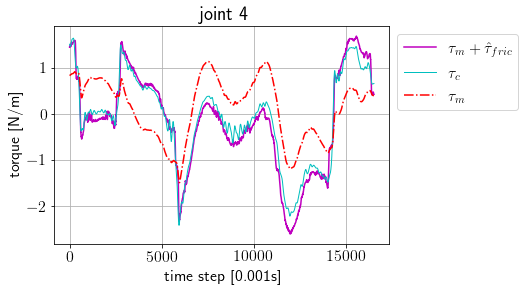

In [47]:
joint = 4
# plt.plot(tau_MCG[:,joint])#+fric_term[:,4]+res_term[:,4])
plt.plot(tau_real_filtered[6000:,joint]+fric_term[6000:,joint], '-m', label=r'$\tau_m + \hat{\tau}_{fric}$', linewidth=1.5)
plt.plot(u_filter[6000:,joint]+G_dat_filter[6000:,joint], '-c', label=r'$\tau_c$', linewidth=1)
plt.plot(tau_real_filtered[6000:,joint], '-.r', label=r"$\tau_m$")
plt.grid()
plt.xlabel('time step [0.001s]')
plt.ylabel('torque [N/m]')
plt.title('joint 4')
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.savefig('/home/jiayun/Desktop/fric_comp.jpg', dpi=150)
plt.show()

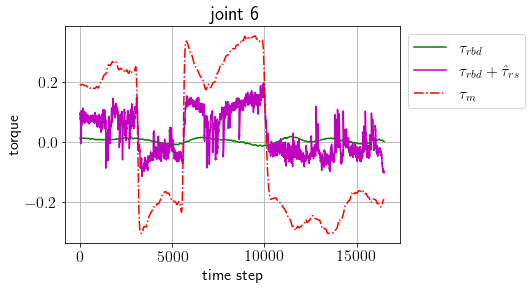

In [48]:
joint = 6
# plt.plot(tau_MCG[:,joint])#+fric_term[:,4]+res_term[:,4])
plt.plot(tau_MCG[6000:, joint], '-g', label=r'$\tau_{rbd}$')
plt.plot(tau_MCG[6000:, joint] + res_term[6000:, joint], '-m', label=r'$\tau_{rbd} + \hat{\tau}_{rs}$', linewidth=1.5)
plt.plot(tau_real_filtered[6000:,joint], '-.r', label=r'$\tau_m$')
plt.grid()
plt.xlabel('time step')
plt.ylabel('torque')
plt.title('joint 6')
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.savefig('/home/jiayun/Desktop/res_comp.jpg', dpi=150)
plt.show()

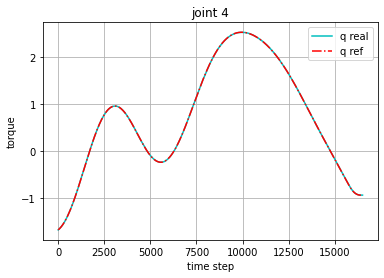

In [28]:
joint = 6
plt.plot(q_real1[6000:, joint], '-c', label='q real')
plt.plot(q_ref1[6000:, joint], '-.r', label='q ref')
# plt.plot(qd_real1[6000:, joint], '-b', label='qd real')
# plt.plot(qd_ref1[6000:, joint], '-.k', label='qd ref')
plt.grid()
plt.xlabel('time step')
plt.ylabel('torque')
plt.title('joint 4')
plt.legend()
plt.savefig('/home/jiayun/Desktop/PID_with_fric_with_res.jpg', dpi=200)
plt.show()

In [39]:
root1 = glob.glob('../data/FricResidualEva/no_camp*')
e_list_1 = []
fric_list_1 = []
res_list_1 = []
for path in root1:
    print(path)
    res = calc_error(path)
    e_list_1.append(res[0])
    fric_list_1.append(res[1])
    res_list_1.append(res[2])

../data/FricResidualEva/no_camp_4.dat
../data/FricResidualEva/no_camp_5.dat
../data/FricResidualEva/no_camp_11.dat
../data/FricResidualEva/no_camp_8.dat
../data/FricResidualEva/no_camp_7.dat
../data/FricResidualEva/no_camp_14.dat
../data/FricResidualEva/no_camp_6.dat
../data/FricResidualEva/no_camp_15.dat
../data/FricResidualEva/no_camp_12.dat
../data/FricResidualEva/no_camp_13.dat


In [40]:
root2 = glob.glob('../data/FricResidualEva/_fric*')
e_list_2 = []
fric_list_2 = []
res_list_2 = []
for path in root2:
    print(path)
    res = calc_error(path)
    e_list_2.append(res[0])
    fric_list_2.append(res[1])
    res_list_2.append(res[2])

../data/FricResidualEva/_fric_3.dat
../data/FricResidualEva/_fric_12.dat
../data/FricResidualEva/_fric_2.dat
../data/FricResidualEva/_fric_7.dat
../data/FricResidualEva/_fric_15.dat
../data/FricResidualEva/_fric_4.dat
../data/FricResidualEva/_fric_1.dat
../data/FricResidualEva/_fric_14.dat
../data/FricResidualEva/_fric_8.dat
../data/FricResidualEva/_fric_9.dat


In [41]:
root3 = glob.glob('../data/FricResidualEva/fric_res*')
e_list_3 = []
fric_list_3 = []
res_list_3 = []
for path in root3:
    print(path)
    res = calc_error(path)
    e_list_3.append(res[0])
    fric_list_3.append(res[1])
    res_list_3.append(res[2])

../data/FricResidualEva/fric_res_14.dat
../data/FricResidualEva/fric_res_9.dat
../data/FricResidualEva/fric_res_11.dat
../data/FricResidualEva/fric_res_4.dat
../data/FricResidualEva/fric_res_1.dat
../data/FricResidualEva/fric_res_3.dat
../data/FricResidualEva/fric_res_7.dat
../data/FricResidualEva/fric_res_10.dat
../data/FricResidualEva/fric_res_12.dat
../data/FricResidualEva/fric_res_13.dat


In [42]:
root4 = glob.glob('../data/FricResidualEva/res*')
e_list_4 = []
fric_list_4 = []
res_list_4 = []
for path in root4:
    print(path)
    res = calc_error(path)
    e_list_4.append(res[0])
    fric_list_4.append(res[1])
    res_list_4.append(res[2])

../data/FricResidualEva/res_8.dat
../data/FricResidualEva/res_12.dat
../data/FricResidualEva/res_13.dat
../data/FricResidualEva/res_4.dat
../data/FricResidualEva/res_2.dat
../data/FricResidualEva/res_3.dat
../data/FricResidualEva/res_7.dat
../data/FricResidualEva/res_15.dat
../data/FricResidualEva/res_11.dat
../data/FricResidualEva/res_5.dat
../data/FricResidualEva/res_14.dat
../data/FricResidualEva/res_10.dat
../data/FricResidualEva/res_6.dat
../data/FricResidualEva/res_9.dat


In [43]:
root5 = glob.glob('../data/FricResidualEva/pid*')
e_list_5 = []
fric_list_5 = []
res_list_5 = []
for path in root5:
    print(path)
    res = calc_error(path)
    e_list_5.append(res[0])
    fric_list_5.append(res[1])
    res_list_5.append(res[2])

../data/FricResidualEva/pid_10.dat
../data/FricResidualEva/pid_4.dat
../data/FricResidualEva/pid_12.dat
../data/FricResidualEva/pid_3.dat
../data/FricResidualEva/pid_13.dat
../data/FricResidualEva/pid_2.dat
../data/FricResidualEva/pid_6.dat
../data/FricResidualEva/pid_8.dat
../data/FricResidualEva/pid_11.dat
../data/FricResidualEva/pid_5.dat
../data/FricResidualEva/pid_15.dat


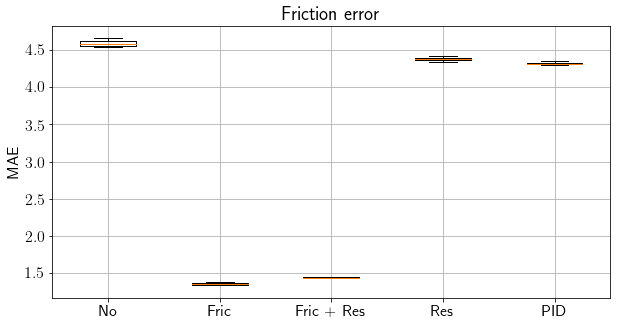

In [53]:
plt.figure(figsize=[10,5])
plt.boxplot([fric_list_1, fric_list_2, fric_list_3, fric_list_4, fric_list_5], 
            labels=['No', 'Fric', 'Fric + Res', 'Res', 'PID'], showfliers=False)

plt.title('Friction error')
plt.ylabel('MAE')
plt.grid()
plt.savefig('/home/jiayun/Desktop/fric_error.jpg', dpi=150)

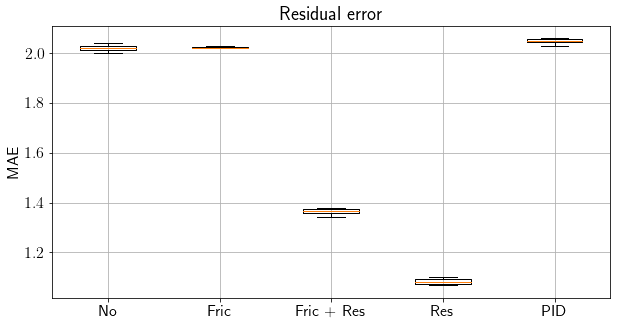

In [54]:
plt.figure(figsize=[10,5])
plt.boxplot([res_list_1, res_list_2, res_list_3, res_list_4, res_list_5], 
            labels=['No', 'Fric', 'Fric + Res', 'Res', 'PID'], showfliers=False)

plt.title('Residual error')
plt.ylabel('MAE')
plt.grid()
plt.savefig('/home/jiayun/Desktop/res_error.jpg', dpi=150)

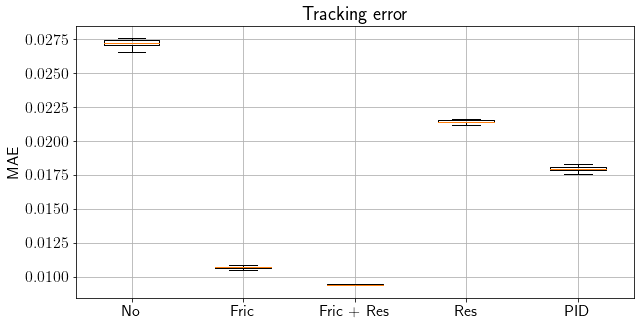

In [55]:
plt.figure(figsize=[10,5])
plt.boxplot([e_list_1, e_list_2, e_list_3, e_list_4, e_list_5], 
            labels=['No', 'Fric', 'Fric + Res', 'Res', 'PID'], showfliers=False)

plt.title('Tracking error')
plt.ylabel('MAE')
plt.grid()
plt.savefig('/home/jiayun/Desktop/tracking_error.jpg', dpi=150)